In [11]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator

In [2]:
load_dotenv()

True

In [3]:
model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

In [4]:
class EvaluationSchema(BaseModel):
    feedback : str =Field(description="detailed feedback on the essay")
    score : int =Field(description="score out of 10 for the essay",ge=0,le=10)
    

In [5]:
structed_model = model.with_structured_output(EvaluationSchema)

In [6]:
essay = """India has contributed to international development by sharing skills and technology, financing and building development projects abroad, providing humanitarian and health assistance, and supporting global peace and multilateral cooperation.

Capacity-building and skills
A flagship pillar is the Indian Technical and Economic Cooperation (ITEC) programme, launched in 1964, through which India provides training, experts, and technical cooperation to partner countries as part of South–South cooperation.

ITEC’s approach emphasizes building local capacity—training civil servants, engineers, health workers, and other professionals—so development gains can continue after a project ends.

Development finance and infrastructure
India supports international development through Lines of Credit (LoCs) that help finance infrastructure and productive projects in partner countries, including sectors like power, railways, technology parks, airports, and public buildings.
​
The Ministry of External Affairs highlights examples such as power projects in African countries, railway projects in Bangladesh and Sri Lanka, the Hanimaadhoo International Airport in Maldives, and the parliament building of Gambia.
​

Health and humanitarian contributions
During COVID-19, India used health diplomacy to support other countries, including the “Vaccine Maitri” initiative that supplied vaccine doses to low-income and partner nations.
​
Academic analysis describes Vaccine Maitri as aimed at equitable access, noting early shipments of vaccine doses provided as grants to multiple countries.

Peacekeeping and global public goods
India has been one of the largest contributors to UN peacekeeping over decades, with reports noting over 290,000 Indian personnel serving in more than 50 missions and thousands deployed in current operations.

By contributing troops, logistics, and operational experience to peacekeeping mandates, India supports stability—often a prerequisite for development, investment, and recovery in conflict-affected regions.

Development partnership principles
A recurring theme in India’s development partnership narrative is demand-driven cooperation—projects shaped by partner-country priorities and implemented in ways meant to strengthen self-reliance rather than create dependency.

This framing aligns with India’s broader positioning as a Global South partner that combines technical assistance, development finance, and multilateral engagement to advance shared development outcomes.

"""

In [31]:
essay2 = """Here's a deliberately bad essay on Indian contribution to international development:

India's Contribution in International Development
India is a country. It is very big and has lots of people. India helps other countries sometimes. This is good thing.

What India Does
India does many things. Like ITEC program. ITEC is program. It started long time ago maybe 1960s or something. They train people from other countries. Training is important because learning is good. People come to India and learn things and go back.

India also gives money to countries. They make lines of credit. Lines of credit means money for projects. Countries use this money to build things like roads and airports and other infrastructure things. This helps countries to develop.

Vaccines and Health
During COVID India made vaccines. India gave vaccines to other countries because COVID was bad disease. Vaccine Maitri was the name. Maitri means friendship in Hindi language. So India was being friendly by giving vaccines. Many countries got vaccines from India because India has big pharmaceutical industry.

Peace and UN
India sends soldiers to UN. UN peacekeeping is when soldiers go to other countries and keep peace there. India sent many soldiers over the years. Maybe millions of soldiers or something like that. This is important for world peace and development because no peace means no development.

Why India Helps
India helps because it wants to be good country. Also India was poor country before so it understands what poor countries need. Now India is developing country so it can help other developing countries. This is called South-South cooperation means developing countries helping each other not just rich countries helping poor countries.

Conclusion
In conclusion India contributes a lot to international development through various programs and initiatives. India should continue doing this because helping is good and makes world better place. Development is important for all countries and India plays important role in this.

"""

In [7]:
prompt = f"Provide detailed feedback and a score out of 10 for the following essay on India's contributions to international development:\n\n{essay}"
response = structed_model.invoke(prompt)

In [9]:
response.score

8

In [12]:
class upscstate(TypedDict):
    essay: str
    lang_feedback: str
    anluysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_score: Annotated[list[int], operator.add]
    avg_score: float

In [14]:
def evaluate_language(state: upscstate):
    prompt = f"Evaluate the language quality of following essay and provide a feedback and a score out of 10 for the following essay :\n\n{state['essay']}"
    output  = structed_model.invoke(prompt)
    
    return {
        'lang_feedback': output.feedback,
        'individual_score': [output.score]}

In [16]:
def evaluate_analysis(state: upscstate):
    prompt = f"Evaluate the depth of analysis  of following essayand provide a feedback and a score out of 10 for the following essay :\n\n{state['essay']}"
    output  = structed_model.invoke(prompt)
    
    return {
        'anluysis_feedback': output.feedback,
        'individual_score': [output.score]}

In [17]:
def evaluate_clarity(state: upscstate):
    prompt = f"Evaluate the clarity of following essayand provide a feedback and a score out of 10 for the following essay :\n\n{state['essay']}"
    output  = structed_model.invoke(prompt)
    
    return {
        'clarity_feedback': output.feedback,
        'individual_score': [output.score]}

In [27]:
def final_evaluation(state: upscstate):
    
    
    #summary 
    prompt = f"Based on the following feedbacks, provide an summarized feedback for the essay:\n\nLanguage Feedback: {state['lang_feedback']}\n\nAnalysis Feedback: {state['anluysis_feedback']}\n\nClarity Feedback: {state['clarity_feedback']}"
    overall_feedback = model.invoke(prompt)
    #avg calculate 
    avg_sum = sum(state['individual_score'])/len(state['individual_score'])
    return {
        'overall_feedback': overall_feedback.content,
        'avg_score': avg_sum}

In [28]:
graph = StateGraph(upscstate)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_clarity',evaluate_clarity)
graph.add_node('final_evaluation',final_evaluation)


graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_clarity')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_clarity','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow = graph.compile()

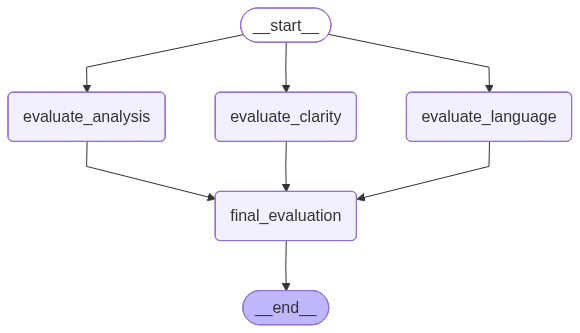

In [29]:
workflow

In [ ]:
intial_state: upscstate = {
    'essay': essay}
result = workflow.invoke(intial_state)
result

{'essay': 'India has contributed to international development by sharing skills and technology, financing and building development projects abroad, providing humanitarian and health assistance, and supporting global peace and multilateral cooperation.\n\nCapacity-building and skills\nA flagship pillar is the Indian Technical and Economic Cooperation (ITEC) programme, launched in 1964, through which India provides training, experts, and technical cooperation to partner countries as part of South–South cooperation.\n\nITEC’s approach emphasizes building local capacity—training civil servants, engineers, health workers, and other professionals—so development gains can continue after a project ends.\n\nDevelopment finance and infrastructure\nIndia supports international development through Lines of Credit (LoCs) that help finance infrastructure and productive projects in partner countries, including sectors like power, railways, technology parks, airports, and public buildings.\n\u200b\nTh

In [32]:
intial_state: upscstate = {
    'essay': essay2}
result = workflow.invoke(intial_state)
result

{'essay': "Here's a deliberately bad essay on Indian contribution to international development:\n\nIndia's Contribution in International Development\nIndia is a country. It is very big and has lots of people. India helps other countries sometimes. This is good thing.\n\nWhat India Does\nIndia does many things. Like ITEC program. ITEC is program. It started long time ago maybe 1960s or something. They train people from other countries. Training is important because learning is good. People come to India and learn things and go back.\n\nIndia also gives money to countries. They make lines of credit. Lines of credit means money for projects. Countries use this money to build things like roads and airports and other infrastructure things. This helps countries to develop.\n\nVaccines and Health\nDuring COVID India made vaccines. India gave vaccines to other countries because COVID was bad disease. Vaccine Maitri was the name. Maitri means friendship in Hindi language. So India was being fri